## Data Loading



In [3]:
from google.colab import files
uploaded = files.upload()

Saving Network_logs.csv to Network_logs (1).csv


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

df_1=pd.read_csv("Network_logs.csv")
df_1.head()

,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type
0,192.168.142.55,42.156.67.167,80,FTP,UDP,2369,curl/7.68.0,Success,0,Normal
1,53.39.165.18,94.60.242.119,135,SMTP,UDP,1536,Wget/1.20.3,Failure,1,BotAttack
2,192.168.127.91,7.10.192.3,21,SMTP,TCP,1183,Wget/1.20.3,Success,0,Normal
3,192.168.30.40,130.169.82.211,25,HTTPS,TCP,666,Mozilla/5.0,Success,0,Normal
4,192.168.43.179,35.140.102.220,22,FTP,TCP,2821,Mozilla/5.0,Success,0,Normal


In [5]:
df_1.info()
df_1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8846 entries, 0 to 8845
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Source_IP       8846 non-null   object
 1   Destination_IP  8846 non-null   object
 2   Port            8846 non-null   int64 
 3   Request_Type    8846 non-null   object
 4   Protocol        8846 non-null   object
 5   Payload_Size    8846 non-null   int64 
 6   User_Agent      8846 non-null   object
 7   Status          8846 non-null   object
 8   Intrusion       8846 non-null   int64 
 9   Scan_Type       8846 non-null   object
dtypes: int64(3), object(7)
memory usage: 691.2+ KB


,Port,Payload_Size,Intrusion
count,8846.000000,8846.000000,8846.000000
mean,887.127741,1598.762831,0.095636
std,4042.073308,915.615023,0.294109
min,21.000000,0.000000,0.000000
25%,22.000000,836.250000,0.000000
50%,53.000000,1580.000000,0.000000
75%,80.000000,2326.000000,0.000000
max,31337.000000,4997.000000,1.000000


The dataset contains 8846 synthetic network log records.  
First, I load the CSV and inspect the structure (head, info, describe).  

## Preprocessing

In [6]:
df_1 = df_1.drop(["User_Agent","Source_IP","Destination_IP"],axis=1)
df_1.head()

,Port,Request_Type,Protocol,Payload_Size,Status,Intrusion,Scan_Type
0,80,FTP,UDP,2369,Success,0,Normal
1,135,SMTP,UDP,1536,Failure,1,BotAttack
2,21,SMTP,TCP,1183,Success,0,Normal
3,25,HTTPS,TCP,666,Success,0,Normal
4,22,FTP,TCP,2821,Success,0,Normal


Some features (`Source_IP`, `Destination_IP`, `User_Agent`) are dataset-specific and risk misleading the model.  
I drop them to improve generalization.  

In [7]:
categorical_columns = ["Request_Type","Protocol","Status"]
cat_df = df_1[categorical_columns]

one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_array = one_hot_encoder.fit_transform(cat_df)
print(encoded_array.shape)

encoded_df = pd.DataFrame(
    encoded_array,
    columns = one_hot_encoder.get_feature_names_out(categorical_columns)
)

print(encoded_df.head())

(8846, 12)
   Request_Type_DNS  Request_Type_FTP  Request_Type_HTTP  Request_Type_HTTPS  \
0               0.0               1.0                0.0                 0.0   
1               0.0               0.0                0.0                 0.0   
2               0.0               0.0                0.0                 0.0   
3               0.0               0.0                0.0                 1.0   
4               0.0               1.0                0.0                 0.0   

   Request_Type_SMTP  Request_Type_SSH  Request_Type_Telnet  Protocol_ICMP  \
0                0.0               0.0                  0.0            0.0   
1                1.0               0.0                  0.0            0.0   
2                1.0               0.0                  0.0            0.0   
3                0.0               0.0                  0.0            0.0   
4                0.0               0.0                  0.0            0.0   

   Protocol_TCP  Protocol_UDP  Status_F

In [8]:
numeric_columns = ["Port", "Payload_Size"]
df_numeric = df_1[numeric_columns].reset_index(drop=True)
X = pd.concat([df_numeric, encoded_df], axis=1)
print(X.shape)
print(X.head())

(8846, 14)
   Port  Payload_Size  Request_Type_DNS  Request_Type_FTP  Request_Type_HTTP  \
0    80          2369               0.0               1.0                0.0   
1   135          1536               0.0               0.0                0.0   
2    21          1183               0.0               0.0                0.0   
3    25           666               0.0               0.0                0.0   
4    22          2821               0.0               1.0                0.0   

   Request_Type_HTTPS  Request_Type_SMTP  Request_Type_SSH  \
0                 0.0                0.0               0.0   
1                 0.0                1.0               0.0   
2                 0.0                1.0               0.0   
3                 1.0                0.0               0.0   
4                 0.0                0.0               0.0   

   Request_Type_Telnet  Protocol_ICMP  Protocol_TCP  Protocol_UDP  \
0                  0.0            0.0           0.0           1.0 

In [9]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_1["Scan_Type"])

print(label_encoder.classes_)
print(y[:10])

['BotAttack' 'Normal' 'PortScan']
[1 0 1 1 1 1 1 1 1 1]


## Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (7076, 14) (7076,)
Test shape: (1770, 14) (1770,)


I split the dataset into 80% training and 20% testing while preserving class distribution using stratified sampling.  


## K-Nearest Neighbors

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)


y_pred = knn.predict(X_test)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

   BotAttack       1.00      0.83      0.91        96
      Normal       0.99      1.00      1.00      1601
    PortScan       1.00      1.00      1.00        73

    accuracy                           0.99      1770
   macro avg       1.00      0.94      0.97      1770
weighted avg       0.99      0.99      0.99      1770

[[  80   16    0]
 [   0 1601    0]
 [   0    0   73]]


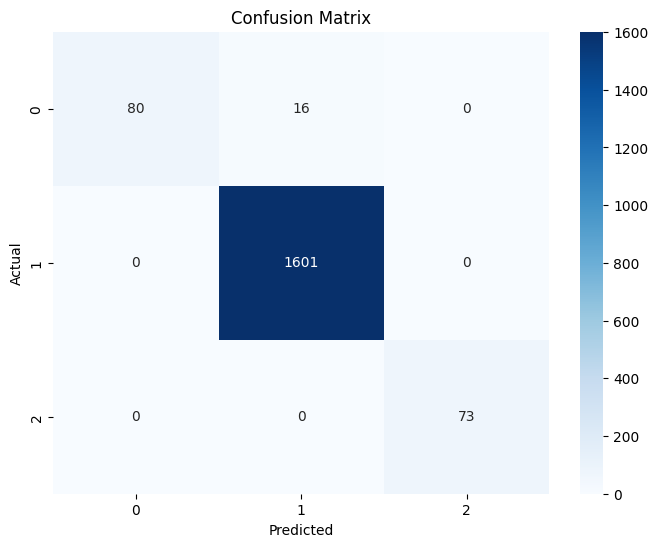

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Training RandomForest
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("RandomForest Results:\n")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print(confusion_matrix(y_test, y_pred_rf))

RandomForest Results:

              precision    recall  f1-score   support

   BotAttack       0.97      0.93      0.95        96
      Normal       1.00      1.00      1.00      1601
    PortScan       0.97      1.00      0.99        73

    accuracy                           0.99      1770
   macro avg       0.98      0.97      0.98      1770
weighted avg       0.99      0.99      0.99      1770

[[  89    7    0]
 [   3 1596    2]
 [   0    0   73]]


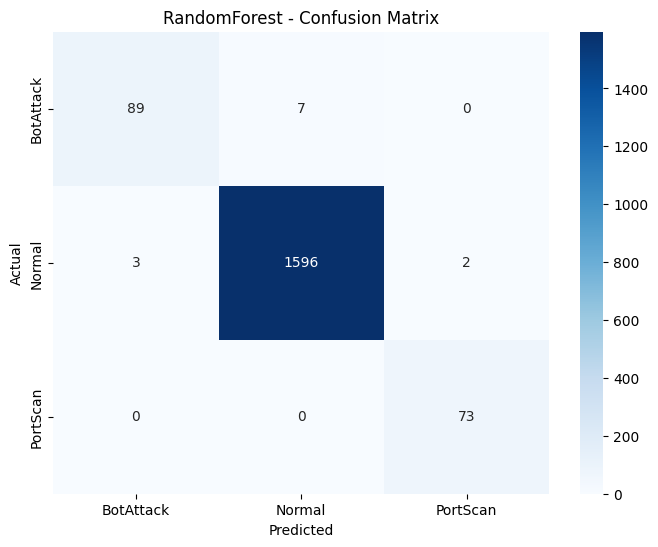

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("RandomForest - Confusion Matrix")
plt.show()
